Martín Amado - 19020
Juan Pablo Pineda - 19087

Referencia para análisis de datos: https://www.kaggle.com/competitions/digit-recognizer/data?select=test.csv

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.cm as cm
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from apyori import apriori

# Ejercicio 1

# Ejercicio 2

## Parte 1: Series de tiempo

### Consumos Diesel

Recaudacion y limpieza de datos

In [20]:
consumption = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
consumption = consumption[['Fecha', 'Diesel']]
#omitimos los datos despues del 269 ya que no aportan relevancia
consumption = consumption[:269]

Desarrollo de la seria de tiempo

In [21]:
trainSize = int(len(consumption) * 0.7)
trainConsumos = consumption[0:trainSize]
testConsumos = consumption[trainSize:len(consumption)]
trainConsumos = trainConsumos.set_index(['Fecha'])
testConsumos = testConsumos.set_index(['Fecha'])

In [22]:
tsDiesel = trainConsumos['Diesel']
mediaMovil = tsDiesel.rolling(window=12).mean()
deMovil = tsDiesel.rolling(window=12).std()

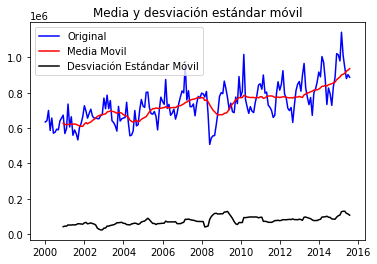

In [23]:
original = plt.plot(tsDiesel, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

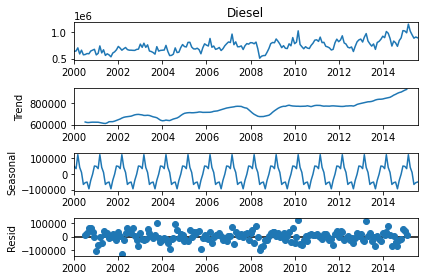

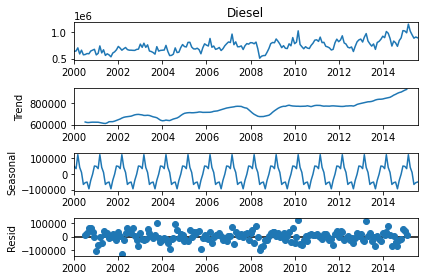

In [26]:
descomposicion = seasonal_decompose(tsDiesel)
descomposicion.plot()

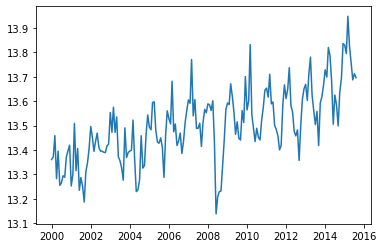

In [27]:
tsDiesel = tsDiesel.astype({'Diesel':'float'})
tsDieselLog = np.log(tsDiesel)
plt.plot(tsDieselLog)

In [30]:
dfTest = adfuller(tsDiesel, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Valor Crítico (%s)'%key] = value
print(salidaDf)

Estadístico de prueba         -0.141801
p-value                        0.945112
# de retardos usados          12.000000
# de observaciones usadas    175.000000
Valor Crítico (1%)            -3.468280
Valor Crítico (5%)            -2.878202
Valor Crítico (10%)           -2.575653
dtype: float64


In [31]:
tsDieselDiff = tsDiesel.diff()
tsDieselDiff.dropna(inplace=True)
dfTest = adfuller(tsDieselDiff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

Estadístico de prueba         -5.536570
p-value                        0.000002
# de retardos usados          11.000000
# de observaciones usadas    175.000000
Critical Value (1%)           -3.468280
Critical Value (5%)           -2.878202
Critical Value (10%)          -2.575653
dtype: float64

Text(0.5, 1.0, 'Diferenciacion de la serie')

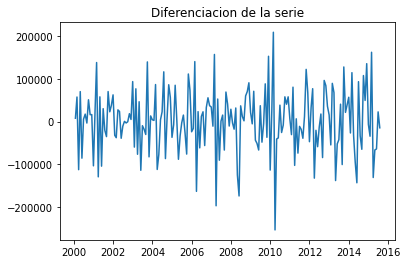

In [32]:
plt.plot(tsDieselDiff)
plt.title('Diferenciacion de la serie')

In [33]:
modelo111 = SARIMAX(tsDieselLog, order=(1,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
resultado_m111.summary().tables[1]

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.0315,0.162,0.194,0.846,-0.286,0.349
ma.L1,-0.6126,0.119,-5.152,0.000,-0.846,-0.380
ar.S.L12,-0.7276,0.087,-8.382,0.000,-0.898,-0.557
ar.S.L24,-0.5636,0.103,-5.480,0.000,-0.765,-0.362
ar.S.L36,-0.3038,0.086,-3.527,0.000,-0.473,-0.135
sigma2,0.0048,0.000,11.515,0.000,0.004,0.006


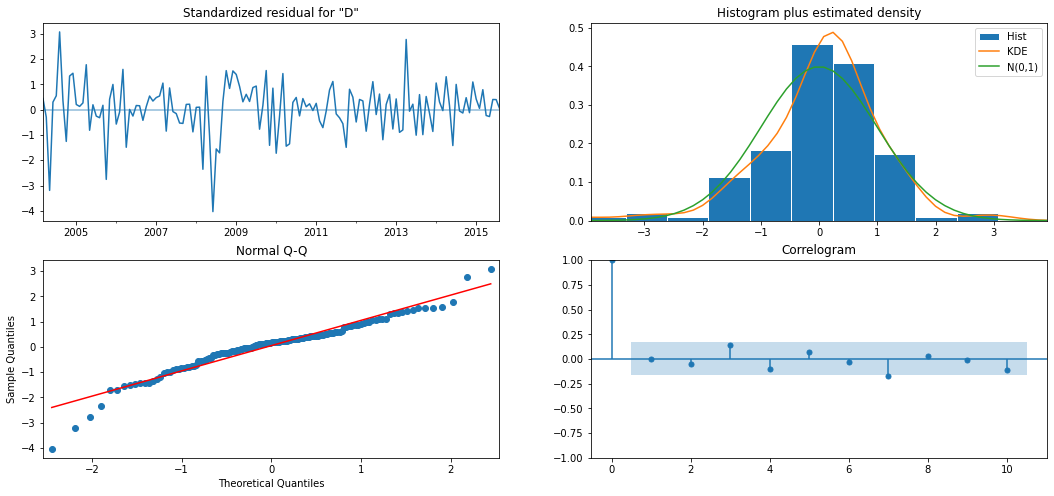

In [34]:
resultado_m111.plot_diagnostics(figsize=(18, 8))
plt.show()

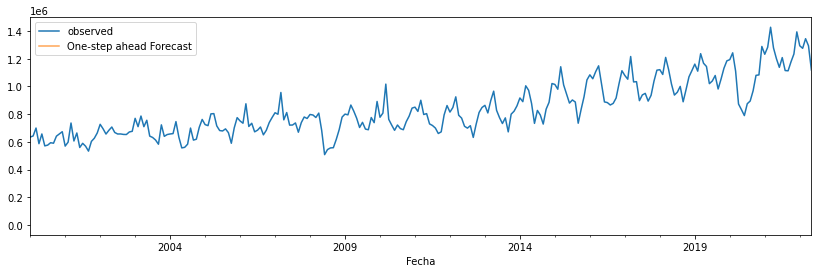

In [38]:
testConsumos.index[0]
pred = resultado_m111.get_prediction(start=testConsumos.index[0], dynamic=False)
pred_ci = pred.conf_int()
consumoIndexed = consumption.set_index('Fecha')
consumoIndexed = consumoIndexed['Diesel']
ax = consumoIndexed['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred

## Parte 2: LSTM